## Plate Segmentation

using **watershed** and **region props**

**scikit-image**: segmentation and regionprops

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

skimage.__version__

'0.15.0'

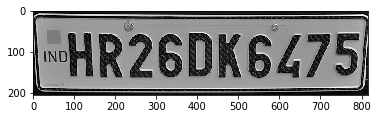

In [2]:
plate = skimage.io.imread('test_plate.jpg', as_gray=True)
plt.imshow(plate, cmap='gray')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


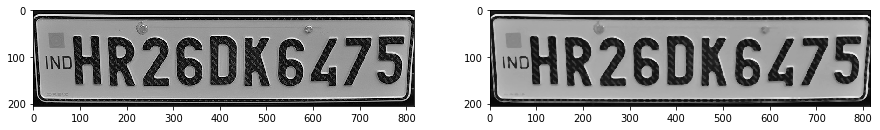

In [3]:
from skimage import filters

plate_denoised = filters.median(plate, selem=np.ones((5,5)))
f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(plate, cmap='gray')
ax1.imshow(plate_denoised, cmap='gray')

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


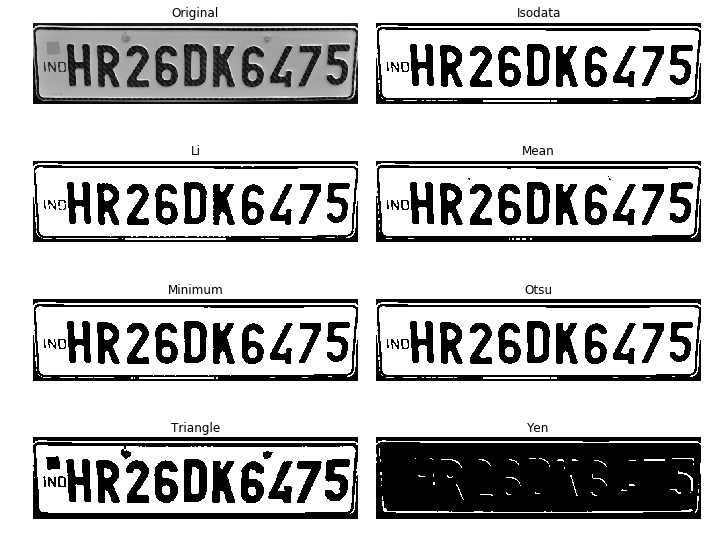

In [4]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(plate_denoised, figsize=(10, 8), verbose=True)
plt.show()

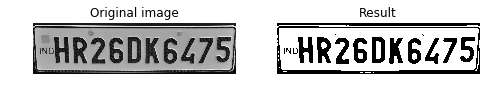

In [5]:
from skimage.filters import threshold_mean


thresh = threshold_mean(plate_denoised)
binary = plate_denoised > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(plate_denoised, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

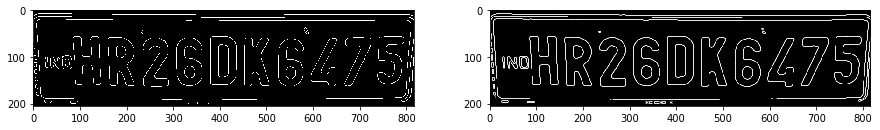

In [6]:
from skimage import feature, filters

edges = skimage.feature.canny(binary, sigma=3)
sobel_edges = skimage.filters.sobel(binary)

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(edges, cmap='gray')
ax1.imshow(sobel_edges, cmap='gray')

Text(0.5, 1.0, 'Euclidian distance')

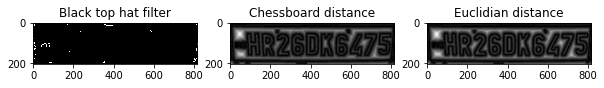

In [7]:
# euclidian distance, chessboard distance and city block (manhattan) distance

from scipy.ndimage import distance_transform_edt, distance_transform_cdt # euclidian distance - distance to closest background pixel
from scipy.ndimage.morphology import black_tophat

euclidian = distance_transform_edt(~edges)
dt = distance_transform_cdt(~edges, metric='chessboard')     # call on negative of edges
blackTopHat = black_tophat(edges, size=(5,5))               # black top hat filter         

fig, ax = plt.subplots(ncols=3, figsize=(10, 5))

ax[0].imshow(blackTopHat, cmap='gray')
ax[0].set_title('Black top hat filter')
ax[1].imshow(dt, cmap='gray')
ax[1].set_title('Chessboard distance')
ax[2].imshow(euclidian, cmap='gray')
ax[2].set_title('Euclidian distance')

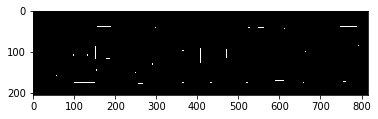

In [8]:
local_max = feature.peak_local_max(dt, indices=False, min_distance=20)
plt.imshow(local_max, cmap='gray')

In [9]:
peak_idx = feature.peak_local_max(dt, indices=True, min_distance=10)
peak_idx[:5]

array([[177, 278],
       [177, 277],
       [177, 276],
       [177, 275],
       [177, 274]])

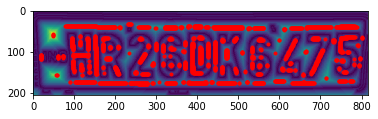

In [10]:
plt.plot(peak_idx[:,1], peak_idx[:,0], 'r.')
plt.imshow(dt)

In [0]:
from skimage import measure

markers = measure.label(local_max)

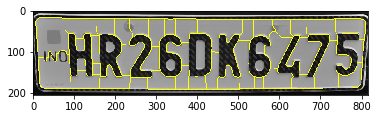

In [12]:
from skimage import morphology, segmentation

labels = morphology.watershed(-dt, markers)     # center of plate becomes trough
plt.imshow(segmentation.mark_boundaries(plate_denoised, labels))

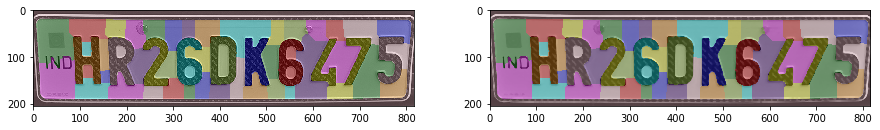

In [13]:
from skimage import color

f, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
ax0.imshow(color.label2rgb(labels, image=plate))
ax1.imshow(color.label2rgb(labels, image=plate_denoised))

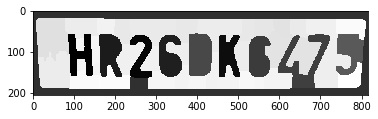

In [14]:
plt.imshow(color.label2rgb(labels, image=plate_denoised, kind='avg'), cmap='gray')